<a href="https://colab.research.google.com/github/dawmro/pytorch_tutorial/blob/main/Text_Classification_Transformers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Imports

In [1]:
import torch
import torch.nn as nn
from torch.optim import Adam
from transformers import AutoTokenizer, AutoModel
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


device = 'cuda' if torch.cuda.is_available() else 'cpu'

print(device)

cuda


# 2. Initializations and Dataset Download

In [2]:
!pip install transformers
!pip install opendatasets

In [3]:
import opendatasets as od
od.download("https://www.kaggle.com/datasets/rmisra/news-headlines-dataset-for-sarcasm-detection")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: dmrotek111@gmail.com
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/rmisra/news-headlines-dataset-for-sarcasm-detection


# 3. Dataset

In [4]:
data_df = pd.read_json("/content/news-headlines-dataset-for-sarcasm-detection/Sarcasm_Headlines_Dataset.json", lines=True)
data_df.dropna(inplace=True)
print(data_df.shape)
data_df.head()

(26709, 3)


,article_link,headline,is_sarcastic
0,https://www.huffingtonpost.com/entry/versace-b...,former versace store clerk sues over secret 'b...,0
1,https://www.huffingtonpost.com/entry/roseanne-...,the 'roseanne' revival catches up to our thorn...,0
2,https://local.theonion.com/mom-starting-to-fea...,mom starting to fear son's web series closest ...,1
3,https://politics.theonion.com/boehner-just-wan...,"boehner just wants wife to listen, not come up...",1
4,https://www.huffingtonpost.com/entry/jk-rowlin...,j.k. rowling wishes snape happy birthday in th...,0


In [14]:
# Possible Outputs
print("Output possibilities: ", data_df["is_sarcastic"].unique())
# Print data shape
print("Data Shape (rows, cols): ", data_df.shape)

Output possibilities:  [0 1]
Data Shape (rows, cols):  (26709, 3)


In [11]:
# Check the distribution of classes
class_distribution = data_df["is_sarcastic"].value_counts()
# Print the distribution
print("Class Distribution:\n", class_distribution)

Output possibilities:  [0 1]
Data Shape (rows, cols):  (26709, 3)
Class Distribution:
 is_sarcastic
0    14985
1    11724
Name: count, dtype: int64


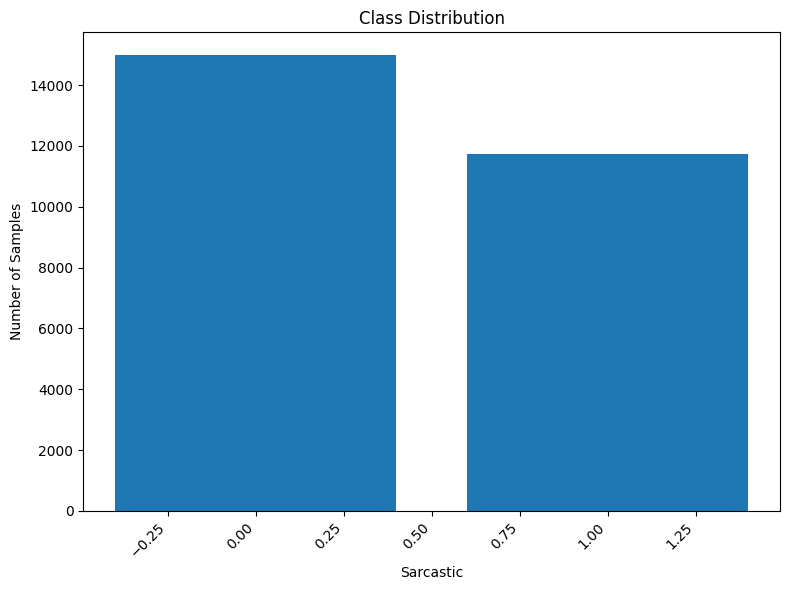

In [13]:
# Visualize the distribution using a bar plot
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
plt.bar(class_distribution.index, class_distribution.values)
plt.title('Class Distribution')
plt.xlabel('Sarcastic')
plt.ylabel('Number of Samples')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()

# 4. Data Splitting

In [5]:
X_train, X_test, y_train, y_test = train_test_split(np.array(data_df["headline"]), np.array(data_df["is_sarcastic"]), test_size=0.3)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5)

In [6]:
print("Training set is: ", X_train.shape[0], " rows which is ", round(X_train.shape[0]/data_df.shape[0],4)*100, "%")
print("Validation set is: ",X_val.shape[0], " rows which is ", round(X_val.shape[0]/data_df.shape[0],4)*100, "%")
print("Testing set is: ",X_test.shape[0], " rows which is ", round(X_test.shape[0]/data_df.shape[0],4)*100, "%")

Training set is:  18696  rows which is  70.0 %
Validation set is:  4006  rows which is  15.0 %
Testing set is:  4007  rows which is  15.0 %


# 5. Download Model and tokenizer

In [16]:
# Initialize the tokenizer using the pre-trained "bert-base-uncased" model
# This tokenizer will be used to convert text into tokens that BERT can understand
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

# Initialize the BERT model using the pre-trained "bert-base-uncased" model
# This model will be used to extract features from the text
bert_model = AutoModel.from_pretrained("bert-base-uncased")

# 6. Determine an appropriate max_length

In [ ]:
# Calculate token lengths
token_lengths = [len(tokenizer.encode(x)) for x in data_df["headline"]]

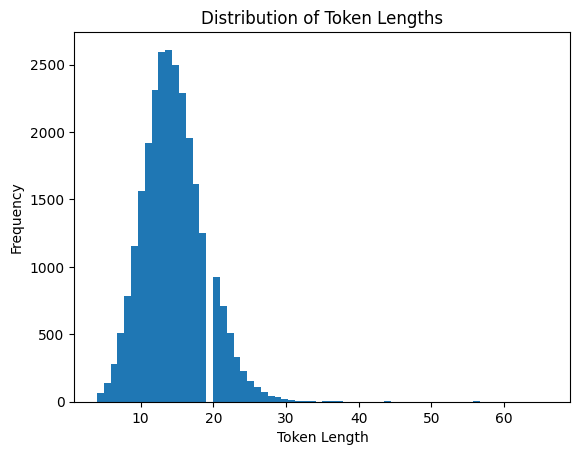

In [34]:
# Distribution of token lengths
plt.hist(token_lengths, bins=int(max(token_lengths)))
plt.title('Distribution of Token Lengths')
plt.xlabel('Token Length')
plt.ylabel('Frequency')
plt.show()

In [44]:
# Determine an acceptable max_length
acceptable_max_length = int(np.percentile(token_lengths, 99.5))
print(acceptable_max_length)

28


# 7. Dataset Object

In [45]:
class dataset(Dataset):
    def __init__(self, X, Y):
        self.X = [tokenizer(x,
                            max_length = acceptable_max_length,
                            truncation = True,
                            padding = 'max_length',
                            return_tensors='pt').to(device)
                  for x in X
                 ]

        self.Y = torch.tensor(Y, dtype = torch.float32).to(device)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, index):
        return self.X[index], self.Y[index]

training_data = dataset(X_train, y_train)
validation_data = dataset(X_val, y_val)
testing_data = dataset(X_test, y_test)

# 8. Training Hyper Parameters

In [46]:
BATCH_SIZE = 32
EPOCHS = 25
LR = 1e-4

# 9. Data Loaders

In [47]:
train_dataloader = DataLoader(training_data, batch_size=BATCH_SIZE, shuffle= True)
validation_dataloader = DataLoader(validation_data, batch_size=BATCH_SIZE, shuffle= True)
testing_dataloader = DataLoader(testing_data, batch_size=BATCH_SIZE, shuffle= True)

# 9. Model Class

In [48]:
class MyModel(nn.Module):
    """
    A custom model class that uses BERT for binary classification.

    Args:
        bert: The pre-trained BERT model.
    """
    def __init__(self, bert):
        """
        Initializes the model.

        Args:
            bert: The pre-trained BERT model.
        """
        super(MyModel, self).__init__()  # Initialize the parent class (nn.Module)

        self.bert = bert  # Store the pre-trained BERT model
        self.dropout = nn.Dropout(0.25)  # Dropout layer for regularization (25% dropout rate)
        self.linear1 = nn.Linear(768, 384)  # First linear layer (input: 768, output: 384)
        self.linear2 = nn.Linear(384, 1)  # Second linear layer (input: 384, output: 1)
        self.sigmoid = nn.Sigmoid()  # Sigmoid activation function for binary classification

    def forward(self, input_ids, attention_mask):
        """
        Performs the forward propagation of the model.

        Args:
            input_ids: The token IDs of the input text.
            attention_mask: The attention mask indicating which tokens to attend to.

        Returns:
            The model's output (a probability score for the binary classification).
        """
        # Get the pooled output from BERT (the output of the [CLS] token)
        pooled_output = self.bert(input_ids, attention_mask, return_dict=False)[0][:, 0]

        # Pass the pooled output through the first linear layer
        output = self.linear1(pooled_output)

        # Apply dropout for regularization
        output = self.dropout(output)

        # Pass the output through the second linear layer
        output = self.linear2(output)

        # Apply the sigmoid activation function to get the final output
        output = self.sigmoid(output)

        return output  # Return the model's output

# 10. Pretraining

In [49]:
# Freeze the pre-trained BERT model weights
# This prevents them from being updated during training
for param in bert_model.parameters():
    param.requires_grad = False

# Create an instance of the custom model, passing the pre-trained BERT model
model = MyModel(bert_model)

# Move the model to the specified device (e.g., CUDA if available)
model.to(device)

MyModel(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affin

# 11. Loss and Optimizer

In [50]:
criterion = nn.BCELoss()
optimizer = Adam(model.parameters(), lr= LR)

# 12. Training Loop

In [51]:
# Initialize lists to store training and validation metrics
total_loss_train_plot = []  # Stores training losses for plotting
total_loss_validation_plot = []  # Stores validation losses for plotting
total_acc_train_plot = []  # Stores training accuracies for plotting
total_acc_validation_plot = []  # Stores validation accuracies for plotting

# Iterate over the specified number of epochs
for epoch in range(EPOCHS):
    # Initialize metrics for the current epoch
    total_acc_train = 0  # Total training accuracy for the epoch
    total_loss_train = 0  # Total training loss for the epoch
    total_acc_val = 0  # Total validation accuracy for the epoch
    total_loss_val = 0  # Total validation loss for the epoch

    # Training loop
    for indx, data in enumerate(train_dataloader):
        # Get the input data and labels from the data loader
        input, label = data

        # Move input and labels to the specified device
        input.to(device)
        label.to(device)

        # Get model predictions
        prediction = model(input['input_ids'].squeeze(1),
                            input['attention_mask'].squeeze(1)).squeeze(1)

        # Calculate the batch loss using the specified criterion
        batch_loss = criterion(prediction, label)

        # Accumulate the total training loss
        total_loss_train += batch_loss.item()

        # Calculate and accumulate the training accuracy
        acc = ((prediction).round() == label).sum().item()
        total_acc_train += acc

        # Backpropagate the loss and update model parameters
        batch_loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    # Validation loop (no gradient calculation)
    with torch.no_grad():
        for indx, data in enumerate(validation_dataloader):
            # Get the input data and labels from the data loader
            input, label = data
            input.to(device)
            label.to(device)

            # Get model predictions
            prediction = model(input['input_ids'].squeeze(1),
                                input['attention_mask'].squeeze(1)).squeeze(1)

            # Calculate the batch validation loss
            batch_loss_val = criterion(prediction, label)
            total_loss_val += batch_loss_val.item()

            # Calculate and accumulate the validation accuracy
            acc = ((prediction).round() == label).sum().item()
            total_acc_val += acc

    # Append metrics to the lists for plotting
    total_loss_train_plot.append(round(total_loss_train / 1000, 4))
    total_loss_validation_plot.append(round(total_loss_val / 100, 4))
    total_acc_train_plot.append(round(total_acc_train / (training_data.__len__()) * 100, 4))
    total_acc_validation_plot.append(round(total_acc_val / (validation_data.__len__()) * 100, 4))

    # Print the epoch results
    print(f'''Epoch no. {epoch + 1} Train Loss: {total_loss_train / 1000:.4f} Train Accuracy: {(total_acc_train / (training_data.__len__()) * 100):.4f} Validation Loss: {total_loss_val / 100:.4f} Validation Accuracy: {(total_acc_val / (validation_data.__len__()) * 100):.4f}''')
    print("=" * 50)

Epoch no. 1 Train Loss: 0.2622 Train Accuracy: 80.0706 Validation Loss: 0.5056 Validation Accuracy: 81.6276
Epoch no. 2 Train Loss: 0.2137 Train Accuracy: 84.2266 Validation Loss: 0.4508 Validation Accuracy: 85.0724
Epoch no. 3 Train Loss: 0.2015 Train Accuracy: 84.9754 Validation Loss: 0.4281 Validation Accuracy: 85.3969
Epoch no. 4 Train Loss: 0.1938 Train Accuracy: 85.7563 Validation Loss: 0.4206 Validation Accuracy: 85.7214
Epoch no. 5 Train Loss: 0.1896 Train Accuracy: 86.0291 Validation Loss: 0.4096 Validation Accuracy: 86.3954
Epoch no. 6 Train Loss: 0.1876 Train Accuracy: 86.2698 Validation Loss: 0.4111 Validation Accuracy: 85.9211
Epoch no. 7 Train Loss: 0.1846 Train Accuracy: 86.6389 Validation Loss: 0.4059 Validation Accuracy: 86.2456
Epoch no. 8 Train Loss: 0.1818 Train Accuracy: 86.6389 Validation Loss: 0.4028 Validation Accuracy: 86.0459
Epoch no. 9 Train Loss: 0.1816 Train Accuracy: 86.5372 Validation Loss: 0.3967 Validation Accuracy: 86.3704
Epoch no. 10 Train Loss: 0.1

# 13. Testing

In [53]:
# Testing loop (no gradient calculation)
with torch.no_grad():  # Disable gradient calculation during testing
    total_loss_test = 0  # Initialize total test loss
    total_acc_test = 0  # Initialize total test accuracy

    # Iterate over the testing data loader
    for indx, data in enumerate(testing_dataloader):
        # Get the input data and labels from the data loader
        input, label = data

        # Move input and labels to the specified device
        input.to(device)
        label.to(device)

        # Get model predictions
        prediction = model(input['input_ids'].squeeze(1), input['attention_mask'].squeeze(1)).squeeze(1)

        # Calculate the batch validation loss
        batch_loss_val = criterion(prediction, label)

        # Accumulate the total test loss
        total_loss_test += batch_loss_val.item()

        # Calculate and accumulate the test accuracy
        acc = ((prediction).round() == label).sum().item()
        total_acc_test += acc

# Print the final test accuracy
print(f"Accuracy Score is: {round((total_acc_test/X_test.shape[0])*100, 2)}%")

Accuracy Score is: 86.82%


# 14. Plotting and Visualizations

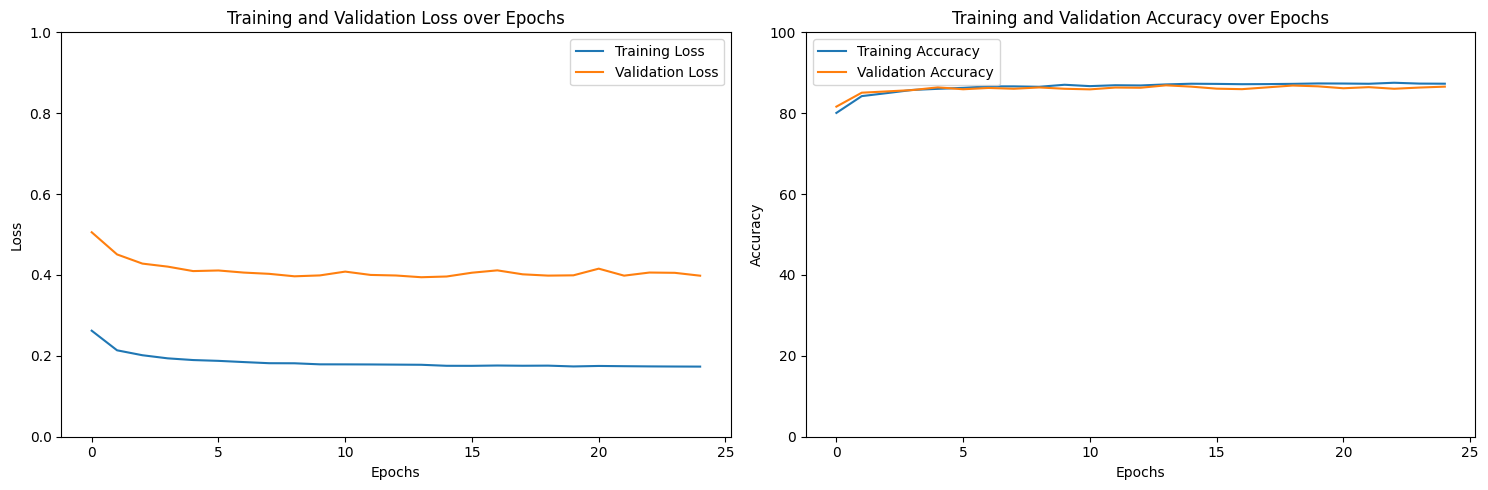

In [54]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

axs[0].plot(total_loss_train_plot, label='Training Loss')
axs[0].plot(total_loss_validation_plot, label='Validation Loss')
axs[0].set_title('Training and Validation Loss over Epochs')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].set_ylim([0, 1])
axs[0].legend()

axs[1].plot(total_acc_train_plot, label='Training Accuracy')
axs[1].plot(total_acc_validation_plot, label='Validation Accuracy')
axs[1].set_title('Training and Validation Accuracy over Epochs')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].set_ylim([0, 100])
axs[1].legend()

plt.tight_layout()

plt.show()